# <span style="color:blue">M2 SIA </span>
* **Hassan EL FENNI** <br>
* **Skander MARNISSI** <br>

# Deezer playlist dataset and song recommendation with word2vec

In this mini project we will develop a word2vec network and use it to build a playlist completion tool (song suggestion). The data is hosted on the following repository: http://github.com/comeetie/deezerplay.git. To know more about word2vec and these data you can read the two following references:

- Efficient estimation of word representations in vector space, Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. (https://arxiv.org/abs/1301.3781)
- Word2with applied to Recommendation: Hyperparameters Matter, H. Caselles-Dupré, F. Lesaint and J. Royo-Letelier. (https://arxiv.org/pdf/1804.04212.pdf)

The elements you have to do are highlighted in red.

## Preparation of data

The data is in the form of a playlist list. Each playlist is a list with the deezer ID of the psong followed by the artist ID.

In [1]:
import numpy as np
data = np.load("./music_2.npy",allow_pickle=True)
[len(data), np.mean([len(p) for p in data])]

[100000, 24.21338]

The dataset we are going to work on contains 100000 playlists which are composed of an average of 24.1 songs. We will start by keeping only the song identifiers. 

In [2]:
playlist_track = [list(filter(lambda w: w.split("_")[0]==u"track",playlist)) for playlist in data]
playlist_artist = [list(filter(lambda w: w.split("_")[0]==u"artist",playlist)) for playlist in data]

In [3]:
# songs != ?
tracks = np.unique(np.concatenate(playlist_track))
Vt = len(tracks)
Vt

338509

The number of different songs in this data-set is quite high with more than 300,000 songs.

## Creating a song dictionary
We will assign to each song an integer that will serve as a unique identifier and input for our network. In order to save a little bit of resources we will only work in this project on songs that appear in at least two playlists.

In [4]:
# how many occurence for each track ? 
track_counts = dict((tracks[i],0) for i in range(0, Vt))
for p in playlist_track:
    for a in p:
        track_counts[a]=track_counts[a]+1;

In [5]:
# Filter very rare songs to save ressources
playlist_track_filter = [list(filter(lambda a : track_counts[a]> 1, playlist)) for playlist in playlist_track]
# get the counts
counts  =  np.array(list(track_counts.values()))
# sort
order = np.argsort(-counts)
# deezed_id array
tracks_list_ordered = np.array(list(track_counts.keys()))[order]
# Vocabulary size = number of kept songs
Vt=np.where(counts[order]==1)[0][0]
# dict construction id_morceaux num_id [0,Vt]
track_dict = dict((tracks_list_ordered[i],i) for i in range(0, Vt))
# playlist conversion to list of integers
corpus_num_track = [[track_dict[track] for track in play ] for play in playlist_track_filter]

### Creation of test and validation learning sets

To learn the parameters of our method we will keep the first l-1 songs of each playlist (with l the length of the playlist) for learning. To evaluate the completion performance of our method we keep for each playlist the last two songs. The objective will be to find the last one from the next-to-last one. 



In [6]:
# playlist main part used for trainning
play_app  = [corpus_num_track[i][:(len(corpus_num_track[i])-1)] 
             for i in range(len(corpus_num_track)) if len(corpus_num_track[i])>1]
# the two last elements are used for validation and training
index_tst = np.random.choice(100000,20000)
index_val = np.setdiff1d(range(100000),index_tst)

play_tst  = np.array([corpus_num_track[i][(len(corpus_num_track[i])-2):len(corpus_num_track[i])] 
             for i in index_tst if len(corpus_num_track[i])>3])
play_val  = np.array([corpus_num_track[i][(len(corpus_num_track[i])-2):len(corpus_num_track[i])] 
             for i in index_val if len(corpus_num_track[i])>3])[:10000]


In [7]:
# import Keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,Flatten
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.preprocessing.sequence import skipgrams

### hyper-paramètres de word2vec :

La méthode word2vec fait intervennir un certains nombre d'hyper paramètres. Nous allons les définirs et leurs donner des première valeurs que nous affinerons par la suite:


In [8]:
# latent space dimension
vector_dim = 30 
# window size
window_width = 3
# number of negative sample per positive sample
neg_sample = 5
# taille des mini-batch
min_batch_size = 50
# smoothing factor for the sampling table of negative pairs 
samp_coef = 0.5
# cparameter to sub-sample frequent song
sub_samp = 0.00001

### Creation of the draw probability tables (smoothed) and unsmoothed

To draw the negative examples we need the smoothed frequencies of each song in our dataset. Likewise to under-sample very frequent pieces we need the raw frequencies. We will calculate these two vectors.

In [9]:
# get the counts
counts = np.array(list(track_counts.values()),dtype='float')[order[:Vt]]
# normalization
st =  counts/np.sum(counts)
# smoothing
st_smooth = np.power(st,samp_coef)
st_smooth = st_smooth/np.sum(st_smooth)

### Building the word2 network with

A word2 network with takes in input two integers corresponding to two songs, these are embedded in a latent space of dimension (vector_dim) thanks to a layer of embedding type (you will have to use the same layer to project the two pieces). Once these two vectors have been extracted, the array must calculate their scalar product normalize appleler cosine distance : 

$$cos(\theta_{ij})=\frac{z_i.z_j}{||z_i||||z_j||}$$

To carry out this treatment you will use a "dot" layer for "dot product". The model then uses a sigmoid layer to produce the output. This output will be 0 when both songs are randomly drawn from the whole dataset and 1 when they were extracted from the same playslist. <span style="color:red">You have to create the keras Track2Vec model corresponding to this architecture.</span>


In [10]:
# inputs
input_target = Input((1,), dtype='int32')
input_context = Input((1,), dtype='int32')

embedding = Embedding(Vt, vector_dim, input_length=1)
target = embedding(input_target)
context = embedding(input_context)
dot_product = Dot(axes=2, normalize=True)([target, context])
dot_product = Flatten()(dot_product)

output = Dense(1, activation='sigmoid',name="classif")(dot_product)

Track2Vec = Model(inputs=[input_target, input_context], outputs=output)
Track2Vec.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])

In [11]:
Track2Vec.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        3697230     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1, 1)         0           embedding[0][0]       

### Creation of the data generator

To learn the projection layer at the heart of our model we will build a generator of positive and negative pair examples of close or random songs from our training data. The following function will allow us to generate such examples from a playlist (seq) provided as input. This function will first build all the pairs of songs that can be extracted from the playlist if they are within (windows) distance of each other. These pairs will constitute the positive pairs. The pairs concerning very frequent songs will be removed with a probability that depends on their frequencies. Finally a number of negative examples (corresponding to neg_samples * positive number of examples) will be randomly drawn using the neg_sampling_table.

In [12]:
# function to generate word2vec positive and begative pairs 
# from an array of int that represent a text ot here a playlist
# params 
# seq : input text or playlist (array of int)
# neg_samples : number of negative sample to generate per positive ones
# neg_sampling_table : sampling table for negative samples
# sub sampling_table : sampling table for sub sampling common words songs
# sub_t : sub sampling parameter
def word2vecSampling(seq,window,neg_samples,neg_sampling_table,sub_sampling_table,sub_t):
    # vocab size
    V = len(neg_sampling_table)
    # extract positive pairs 
    positives = skipgrams(sequence=seq, vocabulary_size=V, window_size=window,negative_samples=0)
    ppairs    = np.array(positives[0])
    # sub sampling
    if (ppairs.shape[0]>0):
        f = sub_sampling_table[ppairs[:,0]]
        subprob = ((f-sub_t)/f)-np.sqrt(sub_t/f)
        tokeep = (subprob<np.random.uniform(size=subprob.shape[0])) | (subprob<0)
        ppairs = ppairs[tokeep,:]
    nbneg     = ppairs.shape[0]*neg_samples
    # sample negative pairs
    if (nbneg > 0):
        negex     = np.random.choice(V, nbneg, p=neg_sampling_table)
        negexcontext = np.repeat(ppairs[:,0],neg_samples)
        npairs    = np.transpose(np.stack([negexcontext,negex]))
        pairs     = np.concatenate([ppairs,npairs],axis=0)
        labels    = np.concatenate([np.repeat(1,ppairs.shape[0]),np.repeat(0,nbneg)])
        perm      = np.random.permutation(len(labels))
        res = [pairs[perm,:],labels[perm]]
    else:
        res=[[],[]]
    return res

In [13]:
import random

def track_ns_generator(corpus_num, nbm):

    while 1:

        # tirage de nbm playlist dans corpus_num
        result = [word2vecSampling(batch, window_width, neg_sample, st_smooth, st, sub_samp) for batch in random.sample(corpus_num, nbm)]
        x_temp = np.array([i for fxres in [rot[0] for rot in result if len(rot[0]) > 0] for i in fxres], dtype=np.int32)

        # création des données x et y 
        y = np.array([i for fyres in [rot[1] for rot in result if len(rot[1]) > 0] for i in fyres], dtype=np.int32)
        x = [x_temp[:,0], x_temp[:,1]]

        yield (x, y)

<span style="color:red">Use this function to build a "track_ns_generator" of data which will generate positive and negative examples from "nbm" playlists randomly drawn from the "corpus_num" dataset provided as input. </span>

## Learning 
You should now be able to learn your first model with the following code. This should take between 15 and 30 min.

## Save latent space
Once the learning is done, we can save the position of the songs in the latent space with the following code:

And latter load it with :

In [14]:
vectors_tracks=np.load("latent_positions.npy")

## Use in completion and evaluation
We can now use this space to make suggestions. <span style="color:red">Build a predict_batch function that takes as input a number vector of songs (seeds), (s) a number of suggestions to make per request, the vectors of the songs in the latent space X and a kd-tree to speed up the computation of closest neighbors. To make its propositions this function will return the indices of the s closest neighbors of each seed. </span> So that these predictions don't take too much time you will use a kd-tree (available in scikit learn) to speed up the search for nearest neighbors.

In [15]:
from sklearn.neighbors import KDTree
kdt = KDTree(vectors_tracks, leaf_size=10, metric='euclidean')

In [16]:
def predict_batch(seeds,k,X,kdt):
    return kdt.query(X[seeds,:], k=k+1, return_distance=False)[:,1:]

<span style="color:red">Use this function to propose songs to complete the playlist of the validation dataset (the seeds correspond to the first column of play_val).</span>

In [17]:
indexes = predict_batch(play_val[:,0],10,vectors_tracks,kdt)
indexes.shape

(10000, 10)

<span style="color:red">Compare these suggestions with the second column of play_val (the songs actually present). To do this you will calculate the hit@10 which is 1 if the song actually present in the playlist is one of the 10 suggestions (this score is averaged over the validation set) and the NDCG@10 (Normalized Discounted Cumulative Gain) which takes into account the order of the suggestions. This second score is worth $1/log2(k+1)$ if proposal k (k between 1 and 10) is the correct proposal and 0 if no proposal is correct. As before you will calculate the average score on the validation set. </span>


In [18]:
NDGCatK=0
for k in [np.where(indexes[i] == value)[0] for i, value in enumerate(play_val[:,1])]:
    if len(k)>0:
        NDGCatK+= sum(1/np.log2(k+2))/len(play_val[:,1])
NDGCatK

0.0788602682780147

In [19]:
n,HitatK = 0,0
for i,value in enumerate(play_val[:,1]):
    if value in indexes[i]:
        n+=1
HitatK = n/len(play_val[:,1])
HitatK

0.1358

## hyper parameters tunning

<span style="color:red">You can now try to vary the hyper parameters to improve your performance. Pay attention to the computing time : prepare a grid with about ten different configurations and evaluate each of them on your validation set.
Evaluate the final performance of the best configuration found on the test set. Don't forget to save your results.</span>



### <span style="color:green"> Introduction </span>

In this part, we want to improve our model's performance by tuning its different hyperparameters.
In order to evaluate our model's performance, we will focus on the two metrics speficied in the paper and which are **HitatK** and **NDGCatK**. <br> 

**Methodology**:
1. Tune each hyperparameter independantly of the others and within the ranges studied by the paper in order to find the best configuration, ie: the configuration that gives the best values for HitatK and NDGCatK. 
2. Vary the number of epochs for the best configuration.

For each configuration tested, we will plot the different results obtained and analyse them. 

**Notes**: 
- In some cases, in order to reduce computing time, we did not go over the whole range of values specified in the paper. 
- The different models have been trained exclusively on CPU. <br>
- Hardware: i7 8th gen mobile processor, 8Gb of RAM.

### <span style="color:green"> 1. Tuning each hyperparameter seperately </span>

In this part, we will vary the value of one hyperparameter at a time while keeping the same initial values for the other hyperparameters. 

The 6 hyperparameters we will be studying and their values given by the initial configuration are :

- Latent space dimension: <br>
>vector_dim = 30 
- Window size: <br>
>window_width = 3
- Number of negative sample per positive sample: <br>
>neg_sample = 5
- Size of mini-batch: <br>
>min_batch_size = 50
- Smoothing factor for the sampling table of negative pairs: <br>
>samp_coef = 0.5
- Parameter to sub-sample frequent song: <br>
>sub_samp = 0.00001

The ranges used to vary the hyperparameters are :
- vector_dim = [30, 50, 100, 150]
- window_width = [2, 3, 5, 7, 10]
- neg_sample = [5, 10, 15, 20]
- batch_size = [32,50,64,128]
- sub_samp = [0.00001, 0.0001, 0.001, 0.01, 0.1]
- samp_coef = [-1, -0.7, -0.5, -0.2, 0, 0.2, 0.5, 0.7, 1]


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Latent space dimension
vector_dim_df = pd.DataFrame({
    "vector_dim": [30, 50, 100, 150],
    "HitatK": [0.1367, 0.1617, 0.1687, 0.171],
    "NDCGatK": [0.078245, 0.095214, 0.097167, 0.099335],
    "Loss": [0.142427, 0.114742, 0.098459, 0.094112],
    "Accuracy": [0.942769, 0.962578, 0.098459,0.094112], 
    "Computational time": ["1222s","1490s","2141s","3069s"] #seconds
})

# Window size
window_size_df = pd.DataFrame({
    "window_width": [2, 3, 5, 7, 10],
    "HitatK": [0.129,0.1382,0.1293,0.1324,0.1278],
    "NDCGatK": [0.075013,0.078309,0.073252,0.072043,0.068509],
    "Loss": [0.135549,0.137247,0.146096,0.158096,0.158004],
    "Accuracy": [0.952044,0.951300,0.948152,0.942412,0.941962],
    "Computational time": ["1105s","1153s","1285s","1403s","1502s"]  
})

# Negative sample
neg_sample_df = pd.DataFrame({
    "neg_sample": [5, 10, 15, 20],
    "HitatK": [0.1312, 0.1456, 0.1492, 0.1517],
    "NDCGatK": [0.075292, 0.084225, 0.086514, 0.089492],
    "Loss": [0.1376, 0.0989, 0.0789, 0.0701],
    "Accuracy": [0.954845, 0.963972, 0.975372, 0.979436], 
    "Computational time": ["1172s","1378s","1552s","1720s"]
})

# Batch size
batch_size_df = pd.DataFrame({
    "batch_size": [32,50,64,128],
    "HitatK": [0.1196, 0.1411, 0.1349, 0.1537],
    "NDCGatK": [0.067406, 0.079060, 0.077350, 0.088123],
    "Loss": [0.170633, 0.138268, 0.122173, 0.109958 ],
    "Accuracy": [0.940096, 0.950772, 0.956177, 0.960092 ],
    "Computational time": ["919s","1202s","1419s","2579s"]
})

# Sub-sample
sub_samp_df = pd.DataFrame({
    "sub_samp": [0.00001, 0.0001, 0.001, 0.01, 0.1],
    "HitatK": [0.135, 0.1328, 0.1417, 0.1348, 0.1355],
    "NDCGatK": [0.076782, 0.075194, 0.080791, 0.076606, 0.077132],
    "Loss": [0.136815, 0.147477, 0.155115, 0.148487, 0.147958],
    "Accuracy": [0.950825, 0.945428, 0.942225, 0.944979, 0.945263],
    "computational time": ["1213s", "1289s", "1313s", "1280s", "1298s"]
})

# Sample coefficient
samp_coef_df = pd.DataFrame({
    "samp_coef": [-1, -0.7, -0.5, -0.2, 0, 0.2, 0.5, 0.7, 1],
    "HitatK": [0.1183, 0.1225, 0.1252, 0.1304, 0.1322, 0.1362, 0.1382, 0.1289, 0.1253],
    "NDCGatK": [0.067492, 0.071643, 0.073671,0.073854, 0.075155, 0.076930, 0.077883, 0.0747599845, 0.0751830452],
    "Loss": [0.107788, 0.121125, 0.121846, 0.120875, 0.122048, 0.125860, 0.134700, 0.1451, 0.1571  ],
    "Accuracy": [0.966035, 0.961345, 0.960475, 0.959724, 0.958255, 0.956003, 0.952650, 0.9483, 0.9432 ],
    "computational time": ["1176s", "1186s", "1177s", "1192s", "1225s", "1232s", "1202s", "1175s", "1184s"]
})

In [23]:
#Function for displaying data frames and printing the max HitatK & NDCGatK

def displayDF(df,hyper):
    display(df)

    print(f"The Max HitatK in this DataFrame is: {max(df['HitatK'])}, at {hyper}: {df.loc[df['HitatK'] == max(df['HitatK']), hyper].values[0]}")
    print(f"The Max NDCGatK in this DataFrame is: {round(max(df['NDCGatK']), 6)}, at {hyper}: {df.loc[df['NDCGatK'] == max(df['NDCGatK']), hyper].values[0]}")

In [24]:
#Function for displaying graphs

def displayHyper(df,hyper,title,lim_hitatk=(0.1, 0.16), lim_ndcgatk=(0.05, 0.1)):

    figure, axes = plt.subplots(1, 2, figsize=(20, 5))

    figure.suptitle(title)

    axes[0].set_title("HitatK param")
    axes[0].set_ylim(lim_hitatk[0], lim_hitatk[1])
    axes[1].set_title("NDCGatK param")
    axes[1].set_ylim(lim_ndcgatk[0], lim_ndcgatk[1])

    sns.set_style("darkgrid", {'axes.grid' : False})
    sns.pointplot(ax=axes[0], x=hyper, y='HitatK', data=df, kind='stars',markers=["x"],linestyles=["--"])
    sns.pointplot(ax=axes[1], x=hyper, y='NDCGatK', data=df, kind='stars',markers=["*"],linestyles=["-"])

#### 1.1 Latent space dimension:

In [25]:
displayDF(vector_dim_df,"vector_dim")

,vector_dim,HitatK,NDCGatK,Loss,Accuracy,Computational time
0,30,0.1367,0.078245,0.142427,0.942769,1222s
1,50,0.1617,0.095214,0.114742,0.962578,1490s
2,100,0.1687,0.097167,0.098459,0.098459,2141s
3,150,0.1710,0.099335,0.094112,0.094112,3069s


The Max HitatK in this DataFrame is: 0.171, at vector_dim: 150
The Max NDCGatK in this DataFrame is: 0.099335, at vector_dim: 150


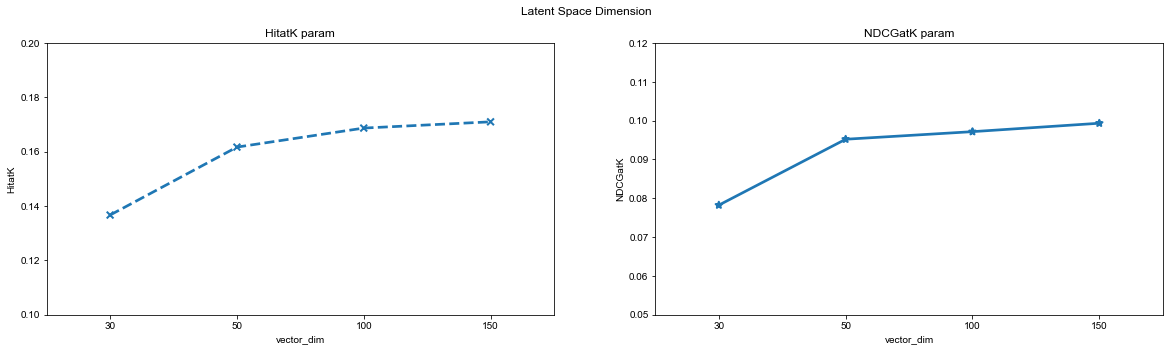

In [26]:
displayHyper(vector_dim_df,"vector_dim","Latent Space Dimension", lim_hitatk=(0.1, 0.2), lim_ndcgatk=(0.05, 0.12))

> We can observe that the performance of the model increases when we increase the dimension of the latent space. However, the biggest jump in performance was met when going from a vector_dim value of 30 to 50, the two curves seem to flatten out at larger dimensions and are likely to reach a plateau.
Another observation we can make is that the computing time taken for training the model goes up exponentially when we increase the number of dimensions.

#### 1.2 Window size:


In [27]:
displayDF(window_size_df,"window_width")

,window_width,HitatK,NDCGatK,Loss,Accuracy,Computational time
0,2,0.1290,0.075013,0.135549,0.952044,1105s
1,3,0.1382,0.078309,0.137247,0.951300,1153s
2,5,0.1293,0.073252,0.146096,0.948152,1285s
3,7,0.1324,0.072043,0.158096,0.942412,1403s
4,10,0.1278,0.068509,0.158004,0.941962,1502s


The Max HitatK in this DataFrame is: 0.1382, at window_width: 3
The Max NDCGatK in this DataFrame is: 0.078309, at window_width: 3


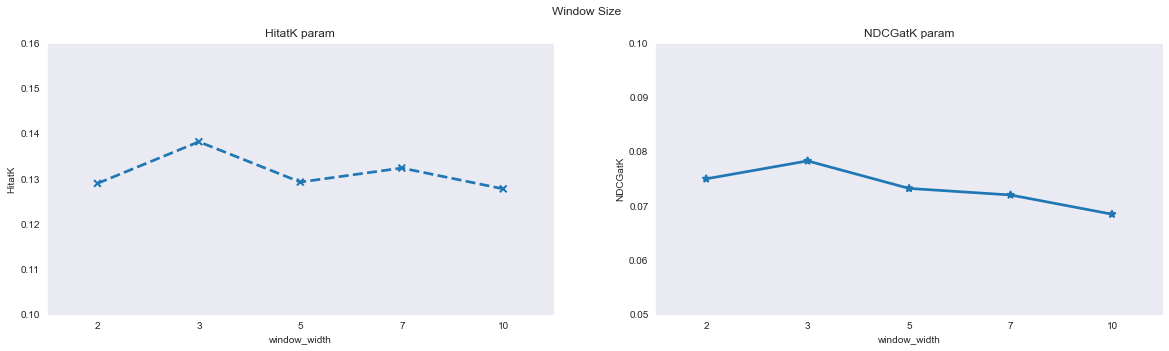

In [28]:
displayHyper(window_size_df,"window_width","Window Size")

> We can see that as the window size increases, the performance of the model decreases with the optimal value for window_width being 3. 
We also notice that the window size has an effect on the training time of the model, the cost increases by +-1minute per unit of window_width. 

#### 1.3 Negative sample:

In [29]:
displayDF(neg_sample_df,"neg_sample")

,neg_sample,HitatK,NDCGatK,Loss,Accuracy,Computational time
0,5,0.1312,0.075292,0.1376,0.954845,1172s
1,10,0.1456,0.084225,0.0989,0.963972,1378s
2,15,0.1492,0.086514,0.0789,0.975372,1552s
3,20,0.1517,0.089492,0.0701,0.979436,1720s


The Max HitatK in this DataFrame is: 0.1517, at neg_sample: 20
The Max NDCGatK in this DataFrame is: 0.089492, at neg_sample: 20


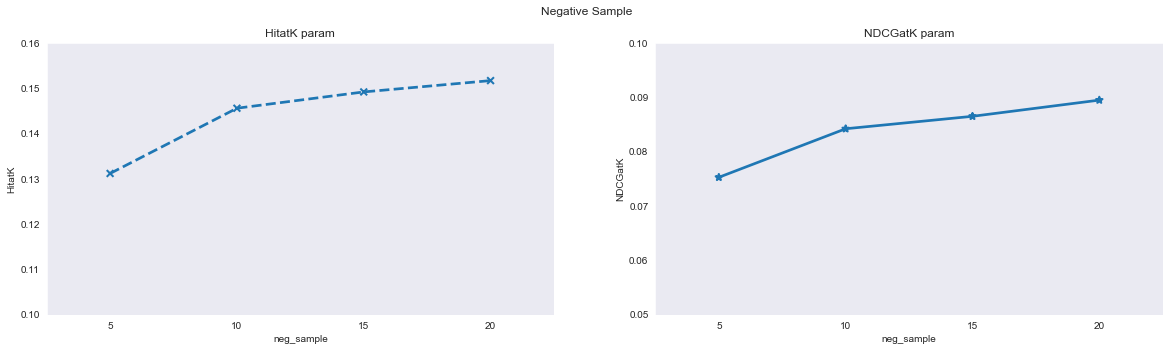

In [30]:
displayHyper(neg_sample_df,"neg_sample","Negative Sample")

> We observe that the performance is increasing along with the number of negative sample. 
Going from a value of 5 to 10 gives us the best performance boost in both HitatK and NDCGatK, the curve seems to flatten out for higher values of neg_sample. The training time seems to be consistently increasing by +-40seconds per unit of neg_sample.

#### 1.4 Batch size:

In [31]:
displayDF(batch_size_df,"batch_size")

,batch_size,HitatK,NDCGatK,Loss,Accuracy,Computational time
0,32,0.1196,0.067406,0.170633,0.940096,919s
1,50,0.1411,0.079060,0.138268,0.950772,1202s
2,64,0.1349,0.077350,0.122173,0.956177,1419s
3,128,0.1537,0.088123,0.109958,0.960092,2579s


The Max HitatK in this DataFrame is: 0.1537, at batch_size: 128
The Max NDCGatK in this DataFrame is: 0.088123, at batch_size: 128


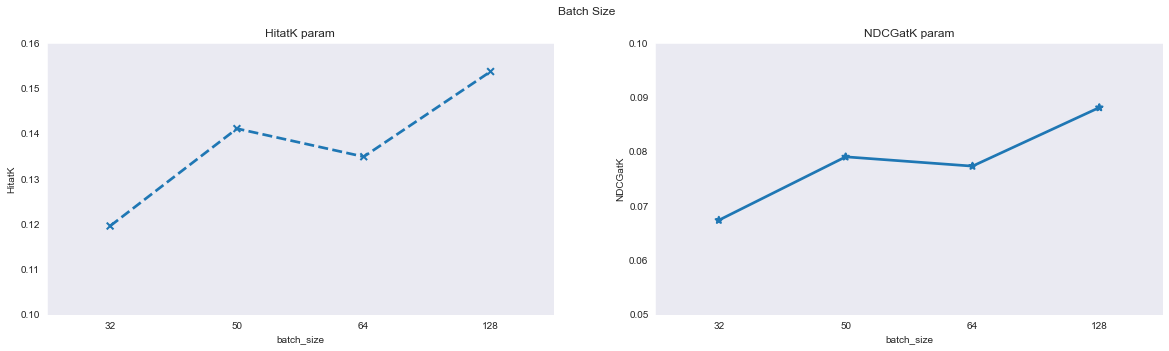

In [32]:
displayHyper(batch_size_df,"batch_size","Batch Size")

> - As to be expected, the performance increases when we increase the batch_size, this is expected because a larger batch_size translates into a less noisy gradient (the gradient is more or less different for each batch depending on its size and the noisiness of the data), this will result in faster **progress** in training. Added to that, the bigger the batch size is, the more likely we are to reaching a global minima, however, batch size is a double edged sword as too big of a batch can result in poor *generalization*. Moroever, a small batch size can help us escape a local minima due to the noisiness of the gradient. 
> - The performance increase associated with bigger batch sizes comes at great cost however, In fact, a bigger batch_size will use more memory (RAM) and, as we can see, even though a bigger batch size results in faster progress in training, this doesn't always translate into faster **convergence**. In our case, bigger batch sizes increase the computational time exponentially. 
> - A possible explanation to this discrepancy is the fact that when you put m examples in a minibatch, you need to perform O(m) computations and use O(m) memory, but you reduce the amount of uncertainty in the gradient by a factor of only O(sqrt(m)). In other words, there are diminishing marginal returns to putting more examples in the minibatch. <br>
> - Finally, more experiments with larger batches are needed in order to draw definitive conclusions for our case. 

#### 1.5 Sub-sample:

In [33]:
displayDF(sub_samp_df,"sub_samp")

,sub_samp,HitatK,NDCGatK,Loss,Accuracy,computational time
0,0.00001,0.1350,0.076782,0.136815,0.950825,1213s
1,0.00010,0.1328,0.075194,0.147477,0.945428,1289s
2,0.00100,0.1417,0.080791,0.155115,0.942225,1313s
3,0.01000,0.1348,0.076606,0.148487,0.944979,1280s
4,0.10000,0.1355,0.077132,0.147958,0.945263,1298s


The Max HitatK in this DataFrame is: 0.1417, at sub_samp: 0.001
The Max NDCGatK in this DataFrame is: 0.080791, at sub_samp: 0.001


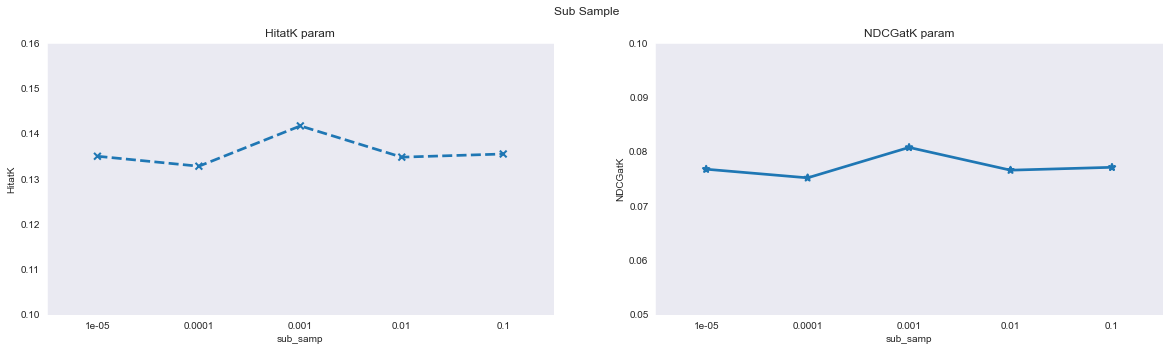

In [34]:
displayHyper(sub_samp_df,"sub_samp","Sub Sample")

> The performance seems to fluctuate as we increase the sub-sample hyperparameter, the best performance is obtained when sub_samp=0.001. <br>
The computing time seems relatively unaffected by the sub-sample value.

#### 1.6 Sample coefficient:

In [35]:
displayDF(samp_coef_df,"samp_coef")

,samp_coef,HitatK,NDCGatK,Loss,Accuracy,computational time
0,-1.0,0.1183,0.067492,0.107788,0.966035,1176s
1,-0.7,0.1225,0.071643,0.121125,0.961345,1186s
2,-0.5,0.1252,0.073671,0.121846,0.960475,1177s
3,-0.2,0.1304,0.073854,0.120875,0.959724,1192s
4,0.0,0.1322,0.075155,0.122048,0.958255,1225s
5,0.2,0.1362,0.076930,0.125860,0.956003,1232s
6,0.5,0.1382,0.077883,0.134700,0.952650,1202s
7,0.7,0.1289,0.074760,0.145100,0.948300,1175s
8,1.0,0.1253,0.075183,0.157100,0.943200,1184s


The Max HitatK in this DataFrame is: 0.1382, at samp_coef: 0.5
The Max NDCGatK in this DataFrame is: 0.077883, at samp_coef: 0.5


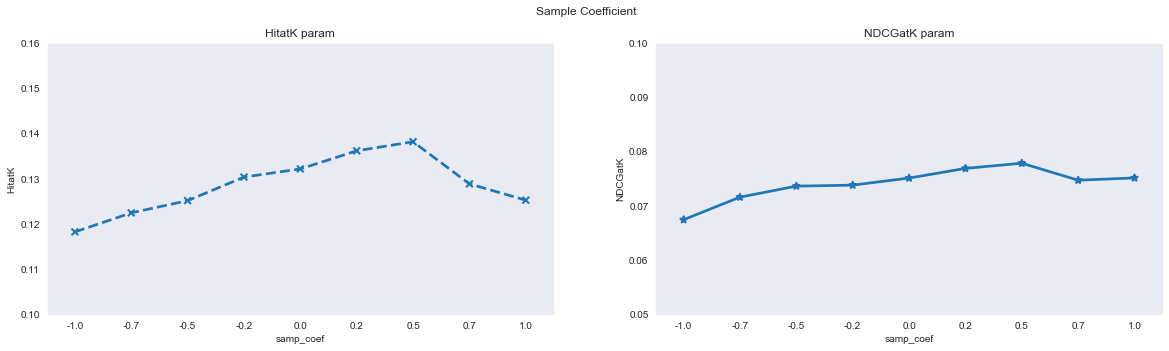

In [36]:
displayHyper(samp_coef_df,"samp_coef","Sample Coefficient")

> The performance increases as we increase the sample coefficient up until a value of 0.5 at which point both curves start to decrease. <br>
> The sample coefficient seems to have no effect on computing time.

###  <span style="color:green"> 2. Effect of the number of training epochs on the optimal configuration <span>

##### The optimal configuration found is the following: 
- vector_dim = 150
- window_width = 3
- neg_sample = 20
- batch_size = 128
- sub_samp = 0.001
- samp_coef = 0.5


In this part, we will study the effect of varying the number of epochs on the performance.
- epochs = [25 , 50, 60]

In [37]:
# Epochs
epochs_df = pd.DataFrame({
    "Epochs": [25, 50, 60],
    "HitatK": [0.192, 0.1847, 0.1954],
    "NDCGatK": [0.11044, 0.108259, 0.11534],
    "Loss": [0.099356, 0.055149, 0.050247],
    "Accuracy": [0.975344, 0.981396, 0.986784], 
    "Computational time": ["8053s", "10787s", "18276s"] 
})

In [38]:
displayDF(epochs_df,"Epochs")

,Epochs,HitatK,NDCGatK,Loss,Accuracy,Computational time
0,25,0.1920,0.110440,0.099356,0.975344,8053s
1,50,0.1847,0.108259,0.055149,0.981396,10787s
2,60,0.1954,0.115340,0.050247,0.986784,18276s


The Max HitatK in this DataFrame is: 0.1954, at Epochs: 60
The Max NDCGatK in this DataFrame is: 0.11534, at Epochs: 60


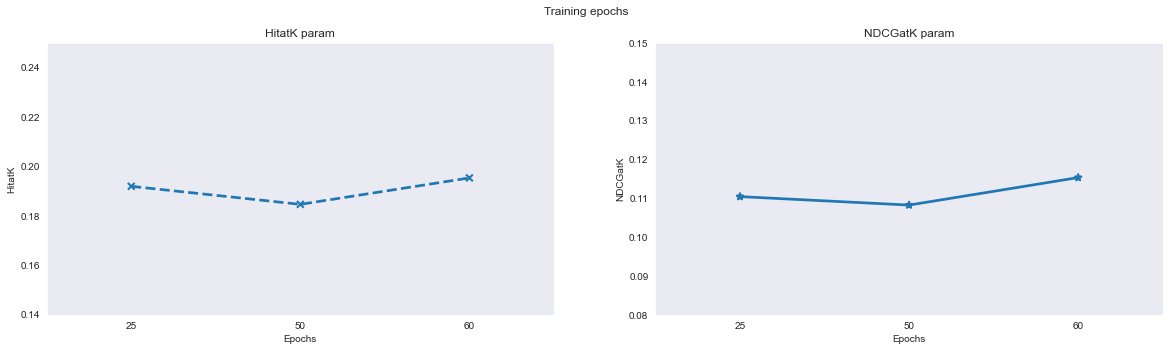

In [39]:
displayHyper(epochs_df,"Epochs","Training epochs", lim_hitatk=(0.14, 0.25), lim_ndcgatk=(0.08, 0.15))

### <span style="color:green">Conclusion</span>

We come to the conclusion that the best performance is obtained using the following hyperparameter setup :

- vector_dim = 150
- window_width = 3
- neg_sample = 20
- batch_size = 128
- samp_coef = 0.001
- sub_samp = 0.5
- epochs = 60

**Note**: Due to the complexity and cost of the training, we have only trained our model on this limited range of epochs, further investigation could possibly lead to better results

## Bonus, a little music

The TrackArtists file contains meta.data on the tracks and the artists for a subset of the 300,000 tracks in the dataset. We can use it to search for the number of a song from its title:

In [40]:
tr_meta=pd.read_csv("./TracksArtists.csv")
joindf = pd.DataFrame({"track_id":tracks_list_ordered[:Vt],"index":range(Vt)})
meta = tr_meta.merge(joindf, left_on="track_id",right_on="track_id")
meta.set_index("index",inplace=True)
meta[["title","name","preview","track_id"]]

,title,name,preview,track_id
index,,,,
14086,Alone,Petit Biscuit,http://cdn-preview-8.deezer.com/stream/c-89176...,track_100001884
1519,Memories,Petit Biscuit,http://cdn-preview-8.deezer.com/stream/c-883c9...,track_102400504
1127,Sunset Lover,Petit Biscuit,NaN,track_102400506
22812,Night Trouble,Petit Biscuit,http://cdn-preview-b.deezer.com/stream/c-b1808...,track_102400604
12644,Palms,Petit Biscuit,http://cdn-preview-3.deezer.com/stream/c-3e57c...,track_102420192
...,...,...,...,...
22784,Donde Estés Llegaré,Alexis y Fido,http://cdn-preview-5.deezer.com/stream/c-542bf...,track_9975788
13071,Camuflaje,Alexis y Fido,http://cdn-preview-b.deezer.com/stream/c-b249e...,track_9975792
22782,Mala Conducta,Alexis y Fido,http://cdn-preview-a.deezer.com/stream/c-af834...,track_9975794


In [41]:
def find_track(title):
    return meta.loc[meta["title"]==title,:].index[0]

tr=find_track("ocean eyes")
tr

17113

## Radio

The deeezer api allows you to retrieve information about the pieces of the dataset from their deezer id. Among this information when it is available a url to listen to a free sample is provided.

In [42]:
import urllib.request, json 
def gettrackinfo(number):
    track_url =  "https://api.deezer.com/track/{}".format(tracks_list_ordered[number].split("_")[1])
    with urllib.request.urlopen(track_url) as url:
        data = json.loads(url.read().decode())
    return data
track_apidata = gettrackinfo(find_track("ocean eyes"))
track_apidata

{'id': 136337268,
 'readable': True,
 'title': 'ocean eyes',
 'title_short': 'ocean eyes',
 'title_version': '',
 'isrc': 'US23A1500056',
 'link': 'https://www.deezer.com/track/136337268',
 'share': 'https://www.deezer.com/track/136337268?utm_source=deezer&utm_content=track-136337268&utm_term=0_1612220157&utm_medium=web',
 'duration': 200,
 'track_position': 1,
 'disk_number': 1,
 'rank': 897029,
 'release_date': '2016-11-18',
 'explicit_lyrics': False,
 'explicit_content_lyrics': 0,
 'explicit_content_cover': 0,
 'preview': 'https://cdns-preview-7.dzcdn.net/stream/c-7bd3f9311d5b85d8ca950fd504f28521-6.mp3',
 'bpm': 145.07,
 'gain': -8.4,
 'available_countries': ['AE',
  'AF',
  'AG',
  'AI',
  'AL',
  'AM',
  'AO',
  'AQ',
  'AR',
  'AS',
  'AT',
  'AU',
  'AZ',
  'BA',
  'BB',
  'BD',
  'BE',
  'BF',
  'BG',
  'BH',
  'BI',
  'BJ',
  'BN',
  'BO',
  'BQ',
  'BR',
  'BT',
  'BV',
  'BW',
  'BY',
  'CA',
  'CC',
  'CD',
  'CF',
  'CG',
  'CH',
  'CI',
  'CK',
  'CL',
  'CM',
  'CO',
  '

So we can use it to listen a preview:

In [43]:
from IPython.display import display, Audio, clear_output
display(Audio(track_apidata["preview"],autoplay=True))

<span style="color:red">Create a radio function that takes as input a track number in the dataset and launches a series of nb_track tracks by randomly pulling in the neighborhood of the current track the next track to listen to. The size of the neighborhood will be configurable and you will delete from the proposals the songs already listened to. You will handle exceptions if the track does not have an available extract. You can delete the current song with the clear_display function.</span>

In [44]:
import time
def start_radio(seed,nb_candidates,duration,nbsteps=20):
    print(meta.loc[seed,"title"])
    display(Audio(meta.loc[seed,"preview"],autoplay=True))
    time.sleep(duration)
    clear_output(True)
    already_played = [seed]
    for i in range(nbsteps):
        print("#{}".format(i+1))
        track = random.choice([t for t in list(predict_batch([already_played[-1]],nb_candidates,vectors_tracks,kdt)[0])
                               if not t in already_played])
        already_played.append(track)
        try:
            print(meta.loc[track,"title"])
            display(Audio(meta.loc[track,"preview"],autoplay=True))
            time.sleep(duration)
        except:
            print("track not found")
            time.sleep(1)
            pass
        clear_output(True)

In [45]:
start_radio(find_track("Sugar"),10,5,20)

#20
track not found
